# <center>Wolff Parkinson White prediction using 1D Convolutional Neural Networks</center>

EDI Project ==> CS-TY59

----------

<b>Wolff-Parkinson-White (WPW)</b>

WPW syndrome is a relatively common heart condition that causes the heart to beat abnormally fast for periods of time. This is due to an extra electrical connection in the heart. This problem with the heart is present at birth (congenital), although symptoms may not develop until later in life. Many cases are diagnosed in otherwise healthy young adults.

Typical ECG findings in patients with WPW is:
* Short PR interval (<120 ms) 
* prolonged QRS complex (>120 ms)
* QRS morphology consisting of a slurred delta wave

In [1]:
# Import the necessary libraries 
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from scipy.io import loadmat
from keras_preprocessing.sequence import pad_sequences

In [2]:

import neurokit2 as nk

In [3]:
def load_challenge_data(filename):
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)
    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)
    with open(input_header_file,'r') as f:
        header_data=f.readlines()
    return data, header_data

In [4]:
normal_sinus_dir = "only_sinus"
wpw_dir = "wpw_dataset"

In [5]:
def import_ecg_data(directory, ecg_len = 5000, trunc="post", pad="post"):
    print("Starting ECG import..")
    ecgs = []
    for ecgfilename in tqdm(sorted(os.listdir(directory))):
        filepath = directory + os.sep + ecgfilename
        if filepath.endswith(".mat"):
            data, header_data = load_challenge_data(filepath)
            data = pad_sequences(data, maxlen=ecg_len, truncating=trunc,padding=pad)
            ecgs.append(data)
    print("Finished!")
    return np.asarray(ecgs)

In [6]:
normal_sinus = import_ecg_data(normal_sinus_dir)
wpw = import_ecg_data(wpw_dir)

Starting ECG import..


100%|██████████| 30180/30180 [01:49<00:00, 276.32it/s] 


Finished!
Starting ECG import..


100%|██████████| 320/320 [00:13<00:00, 24.31it/s]

Finished!


In [7]:
def resample_beats(beats):
    rsmp_beats=[]
    for i in beats:
        i = np.asarray(i)

        #i = i[~np.isnan(i)]
        f = signal.resample(i, 250)
        rsmp_beats.append(f)
    rsmp_beats = np.asarray(rsmp_beats)
    return rsmp_beats

def median_beat(beat_dict):
    beats = []
    for i in beat_dict.values():
        #print(i['Signal'])
        beats.append(i['Signal'])
    beats = np.asarray(beats)
    rsmp_beats = resample_beats(beats)
    med_beat = np.median(rsmp_beats,axis=0)
    return med_beat

def process_ecgs(raw_ecg):    
    processed_ecgs=[]
    for i in tqdm(range(len(raw_ecg))):
        leadII = raw_ecg[i][1]
        leadII_clean = nk.ecg_clean(leadII, sampling_rate=500, method="neurokit")
        r_peaks = nk.ecg_findpeaks(leadII_clean, sampling_rate=500, method="neurokit", show=False)
        twelve_leads = []
        for j in raw_ecg[i]:
            try:
                beats = nk.ecg_segment(j, rpeaks=r_peaks['ECG_R_Peaks'], sampling_rate=500, show=False)
                med_beat = median_beat(beats)
                twelve_leads.append(med_beat)
            except:
                beats = np.ones(250)*np.nan
                twelve_leads.append(beats)
        #twelve_leads = np.asarray(twelve_leads)
        processed_ecgs.append(twelve_leads)
    processed_ecgs = np.asarray(processed_ecgs)
    return processed_ecgs

In [8]:
#For test purpose we chose to only use a fraction of the total ECGs

#norm_ecgs = process_ecgs(normal_sinus)
norm_ecgs = process_ecgs(normal_sinus[:100,:,:])


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


In [9]:
#For test purpose we chose to only use a fraction of the total ECGs

# wpw_ecgs = process_ecgs(wpw)
wpw_ecgs = process_ecgs(wpw[:100,:,:])

 89%|████████▉ | 89/100 [00:50<00:06,  1.76it/s]c:\Programming\Python310\lib\site-packages\neurokit2\signal\signal_period.py:68: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


In [10]:
def remove_nans(ecg_arr):
    new_arr = []
    for i in tqdm(ecg_arr):
        twelve_lead = []
        for j in i:
            if j[0] != j[0]:
                j = np.ones(250)
            twelve_lead.append(j)
        new_arr.append(twelve_lead)
    new_arr = np.asarray(new_arr)
    return new_arr

In [11]:
# Remove missing values 
new_norm = remove_nans(norm_ecgs)
new_wpw = remove_nans(wpw_ecgs)

100%|██████████| 100/100 [00:00<00:00, 49866.89it/s]


In [12]:
def remove_some_ecgs(ecg_arr):
    delete_list = []
    for i in tqdm(range(len(ecg_arr))):
        if np.all(ecg_arr[i].T[0]==1):
            delete_list.append(i)
    ecg_arr = np.delete(ecg_arr,delete_list,axis=0)
    return ecg_arr

In [13]:
# delete some of the ECGs with errors
clean_wpw = remove_some_ecgs(new_wpw)
clean_norm = remove_some_ecgs(new_norm)

100%|██████████| 100/100 [00:00<00:00, 99769.36it/s]


In [14]:
# Reshape the ECG arrays
clean_wpw = np.moveaxis(clean_wpw, 1, -1)
clean_norm = np.moveaxis(clean_norm, 1, -1)

In [15]:
# training split normal ECG
norm_train = clean_norm[:-30]
norm_val = clean_norm[-30:]

In [16]:
# training split WPW ECG
wpw_train = clean_wpw[:50]
wpw_val = clean_wpw[50:]

In [17]:
y_norm_train = np.zeros(norm_train.shape[0])
y_norm_val = np.zeros(norm_val.shape[0])
y_wpw_train = np.ones(wpw_train.shape[0])
y_wpw_val = np.ones(wpw_val.shape[0])

In [18]:
X_train = np.vstack([norm_train,wpw_train])
y_train = np.hstack([y_norm_train,y_wpw_train])

In [19]:
X_val = np.vstack([norm_val,wpw_val])
y_val = np.hstack([y_norm_val,y_wpw_val])

In [20]:
def FCN():
    inputlayer = keras.layers.Input(shape=(250,12), name="first_layer") 

    conv1 = keras.layers.Conv1D(filters=128, kernel_size=15,input_shape=(250,12), padding='same', name="first_conv")(inputlayer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activation='relu')(conv1)
    conv1 = keras.layers.SpatialDropout1D(0.1)(conv1)

    conv2 = keras.layers.Conv1D(filters=256, kernel_size=10, padding='same')(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Activation('relu')(conv2)
    conv2 = keras.layers.SpatialDropout1D(0.1)(conv2)

    conv3 = keras.layers.Conv1D(512, kernel_size=5,padding='same', name="last_conv")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation('relu')(conv3)
    conv3 = keras.layers.Dropout(0.2)(conv3)

    gap_layer = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = tf.keras.layers.Dense(units=2,activation='softmax')(gap_layer)

    model = keras.Model(inputs=inputlayer, outputs=output_layer)
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])
    return model

In [21]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=1, verbose=1, mode='max',
    min_delta=0.0001, cooldown=5, min_lr=0
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=3, patience=15, restore_best_weights=True)

In [22]:
class_weights = np.ones(shape=(len(y_train),))
class_weights[y_train == 1] = len(norm_train)/len(wpw_train)

In [31]:
model = FCN()
batchsize=30
model.fit(x=X_train,y=tf.keras.utils.to_categorical(y_train), epochs=50, batch_size=batchsize, 
          validation_data=(X_val,tf.keras.utils.to_categorical(y_val)),steps_per_epoch=(len(X_train)/batchsize), 
          shuffle=True, sample_weight=class_weights, callbacks=[reduce_lr,early_stop])
model.save('wpw_model.h5')

Epoch 1/50
4/4 [==============================] - 3s 522ms/step - loss: 0.8952 - accuracy: 0.6333 - val_loss: 0.9822 - val_accuracy: 0.6203 - lr: 1.0000e-04
Epoch 2/50
4/4 [==============================] - ETA: 0s - loss: 0.5806 - accuracy: 0.8083
Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
4/4 [==============================] - 2s 434ms/step - loss: 0.5806 - accuracy: 0.8083 - val_loss: 1.2032 - val_accuracy: 0.6203 - lr: 1.0000e-04
Epoch 3/50
4/4 [==============================] - 2s 414ms/step - loss: 0.5270 - accuracy: 0.8167 - val_loss: 1.0176 - val_accuracy: 0.6203 - lr: 1.0000e-05
Epoch 4/50
4/4 [==============================] - 2s 411ms/step - loss: 0.4897 - accuracy: 0.8250 - val_loss: 0.8972 - val_accuracy: 0.6203 - lr: 1.0000e-05
Epoch 5/50
4/4 [==============================] - 2s 415ms/step - loss: 0.4910 - accuracy: 0.8417 - val_loss: 0.8070 - val_accuracy: 0.6203 - lr: 1.0000e-05
Epoch 6/50
4/4 [==============================] - 2s 393ms

In [32]:
loss, acc = model.evaluate(x = X_val, y = tf.keras.utils.to_categorical(y_val), batch_size=1 )
print("Accuracy : {} , Loss: {}".format(acc,loss))

79/79 [==============================] - 1s 8ms/step - loss: 0.4476 - accuracy: 0.8861
Accuracy : 0.8860759735107422 , Loss: 0.44760146737098694


# LIME Model agnostic explanation

In [33]:
import lime
from lime import lime_tabular

In [34]:
def average_and_rebin(array, bin_size):
    new_arr =[]
    temp_len = int(len(array)/bin_size)
    for i in range(temp_len):
        bin = []
        for j in range(bin_size):
            bin_val = array[j + (i*bin_size)]
            bin.append(bin_val)
        new_arr.append(np.repeat(np.mean(bin),bin_size))
    return np.asarray(new_arr).ravel()

In [35]:
explainer = lime_tabular.RecurrentTabularExplainer(X_val[:-6],training_labels=tf.keras.utils.to_categorical(y_val[:-10]), feature_names=["Lead-I","Lead-II", "Lead-III","aVR","aVL","aVF","V1","V2","V3","V4","V5","V6"],
                                                   discretize_continuous=False, feature_selection='auto', class_names=['Normal','WPW'])

predicted labels: 
1/1 [==============================] - 0s 151ms/step
[0.4581085 0.5418916]
-----------------------
WPW = 1, Normal = 0
correct label is: 1.0
-----------------------
157/157 [==============================] - 12s 76ms/step


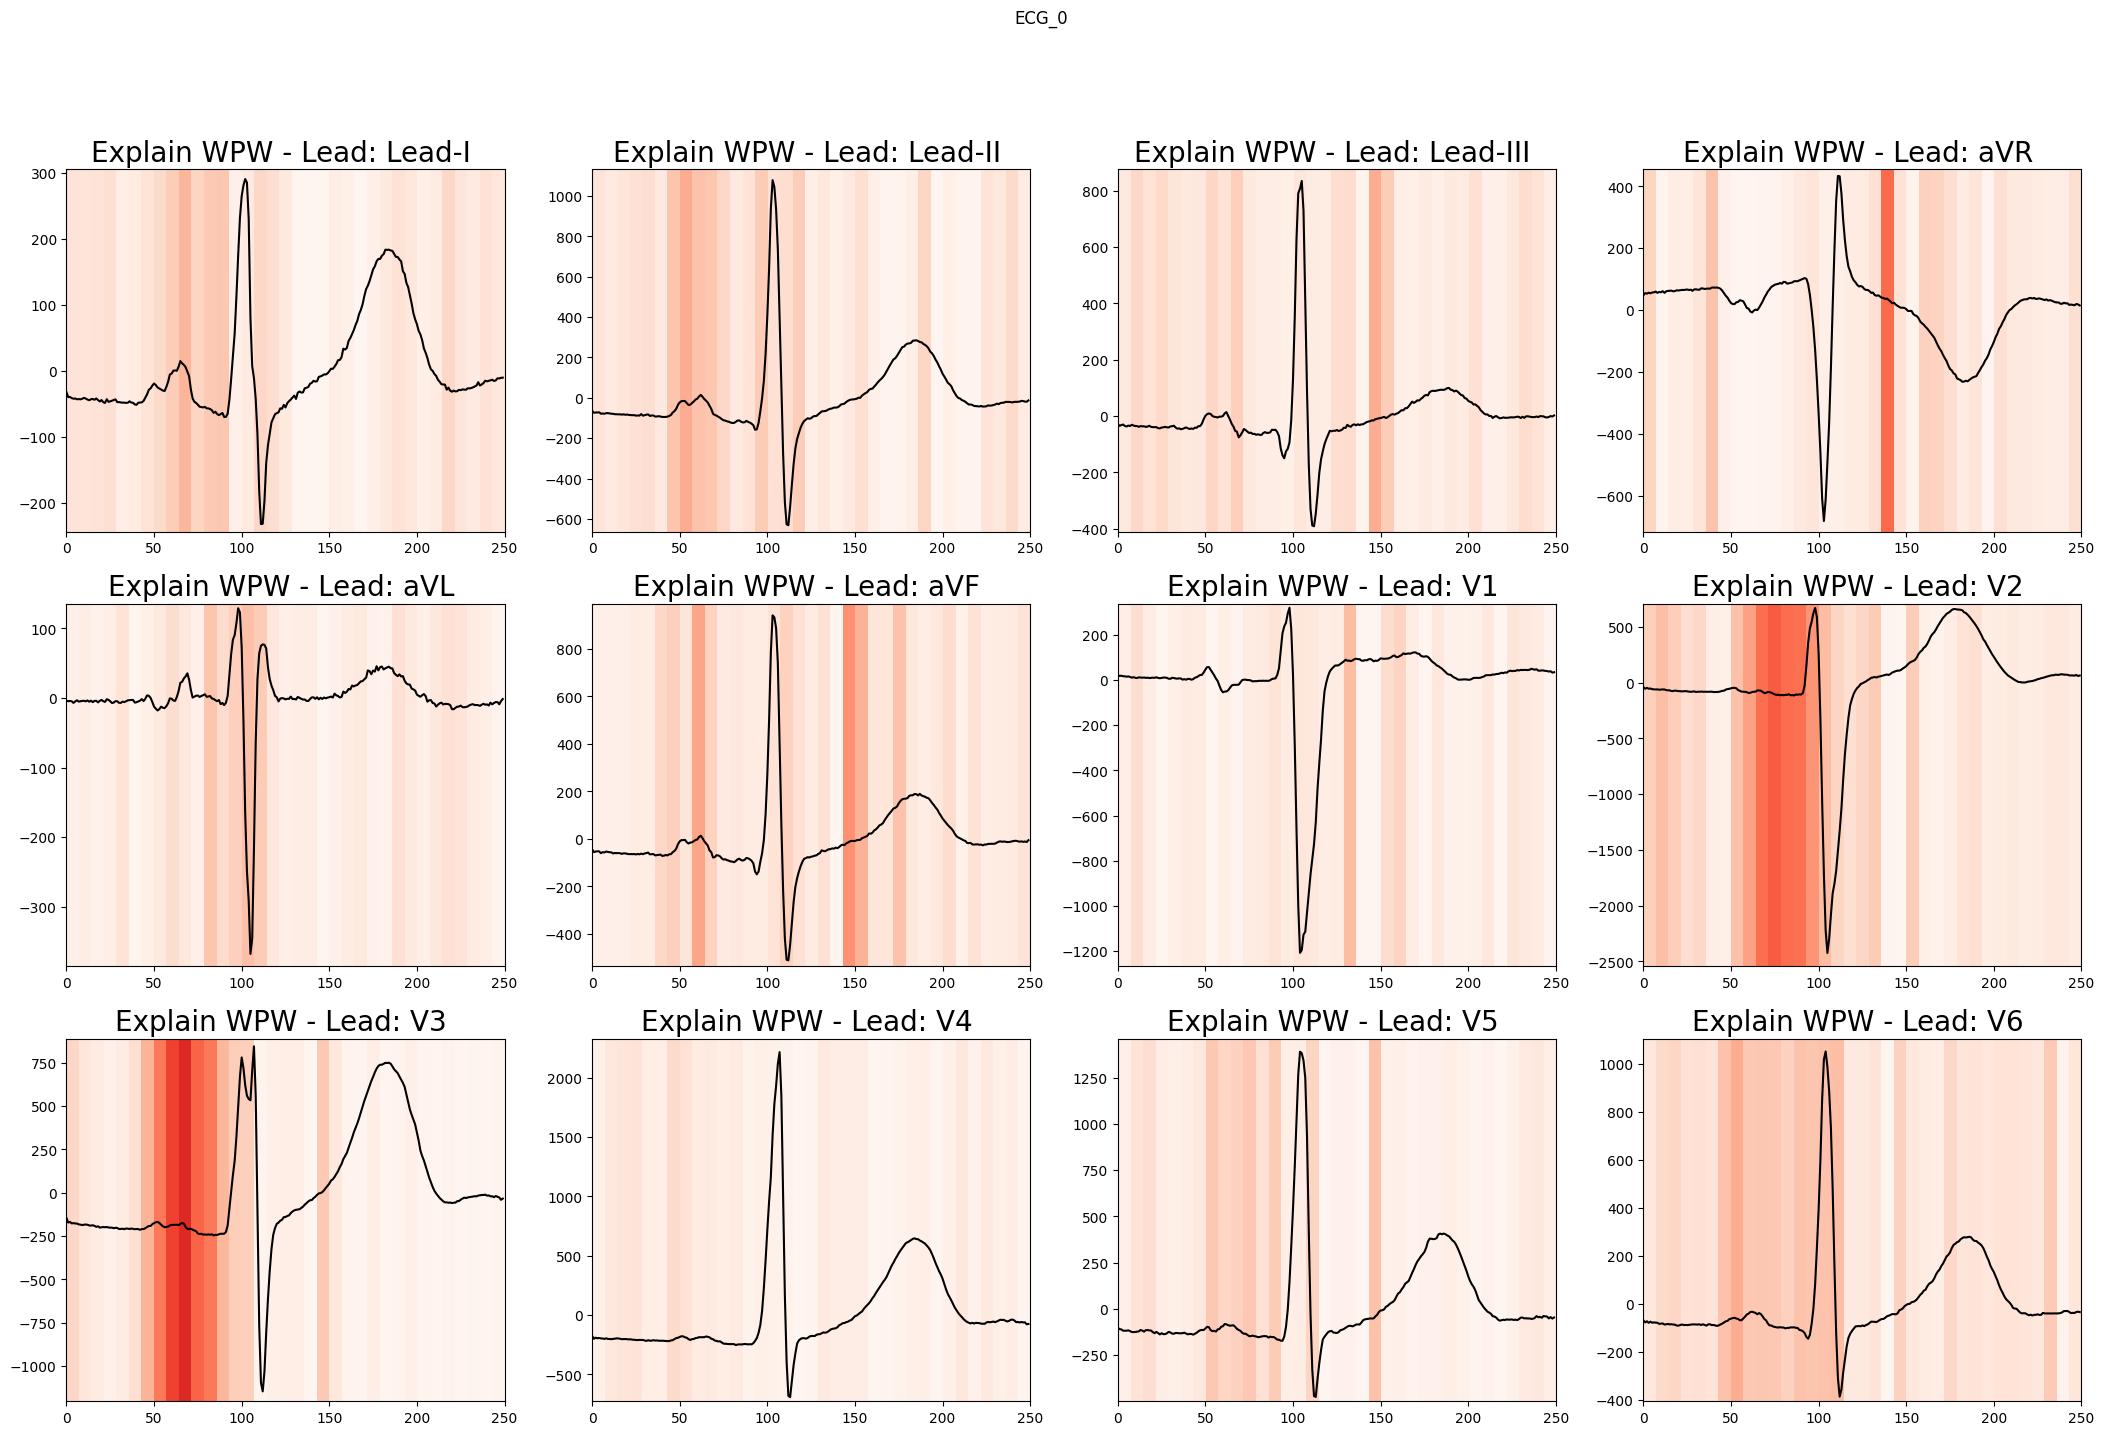

predicted labels: 
1/1 [==============================] - 0s 20ms/step
[0.52538073 0.47461927]
-----------------------
WPW = 1, Normal = 0
correct label is: 1.0
-----------------------
157/157 [==============================] - 11s 71ms/step


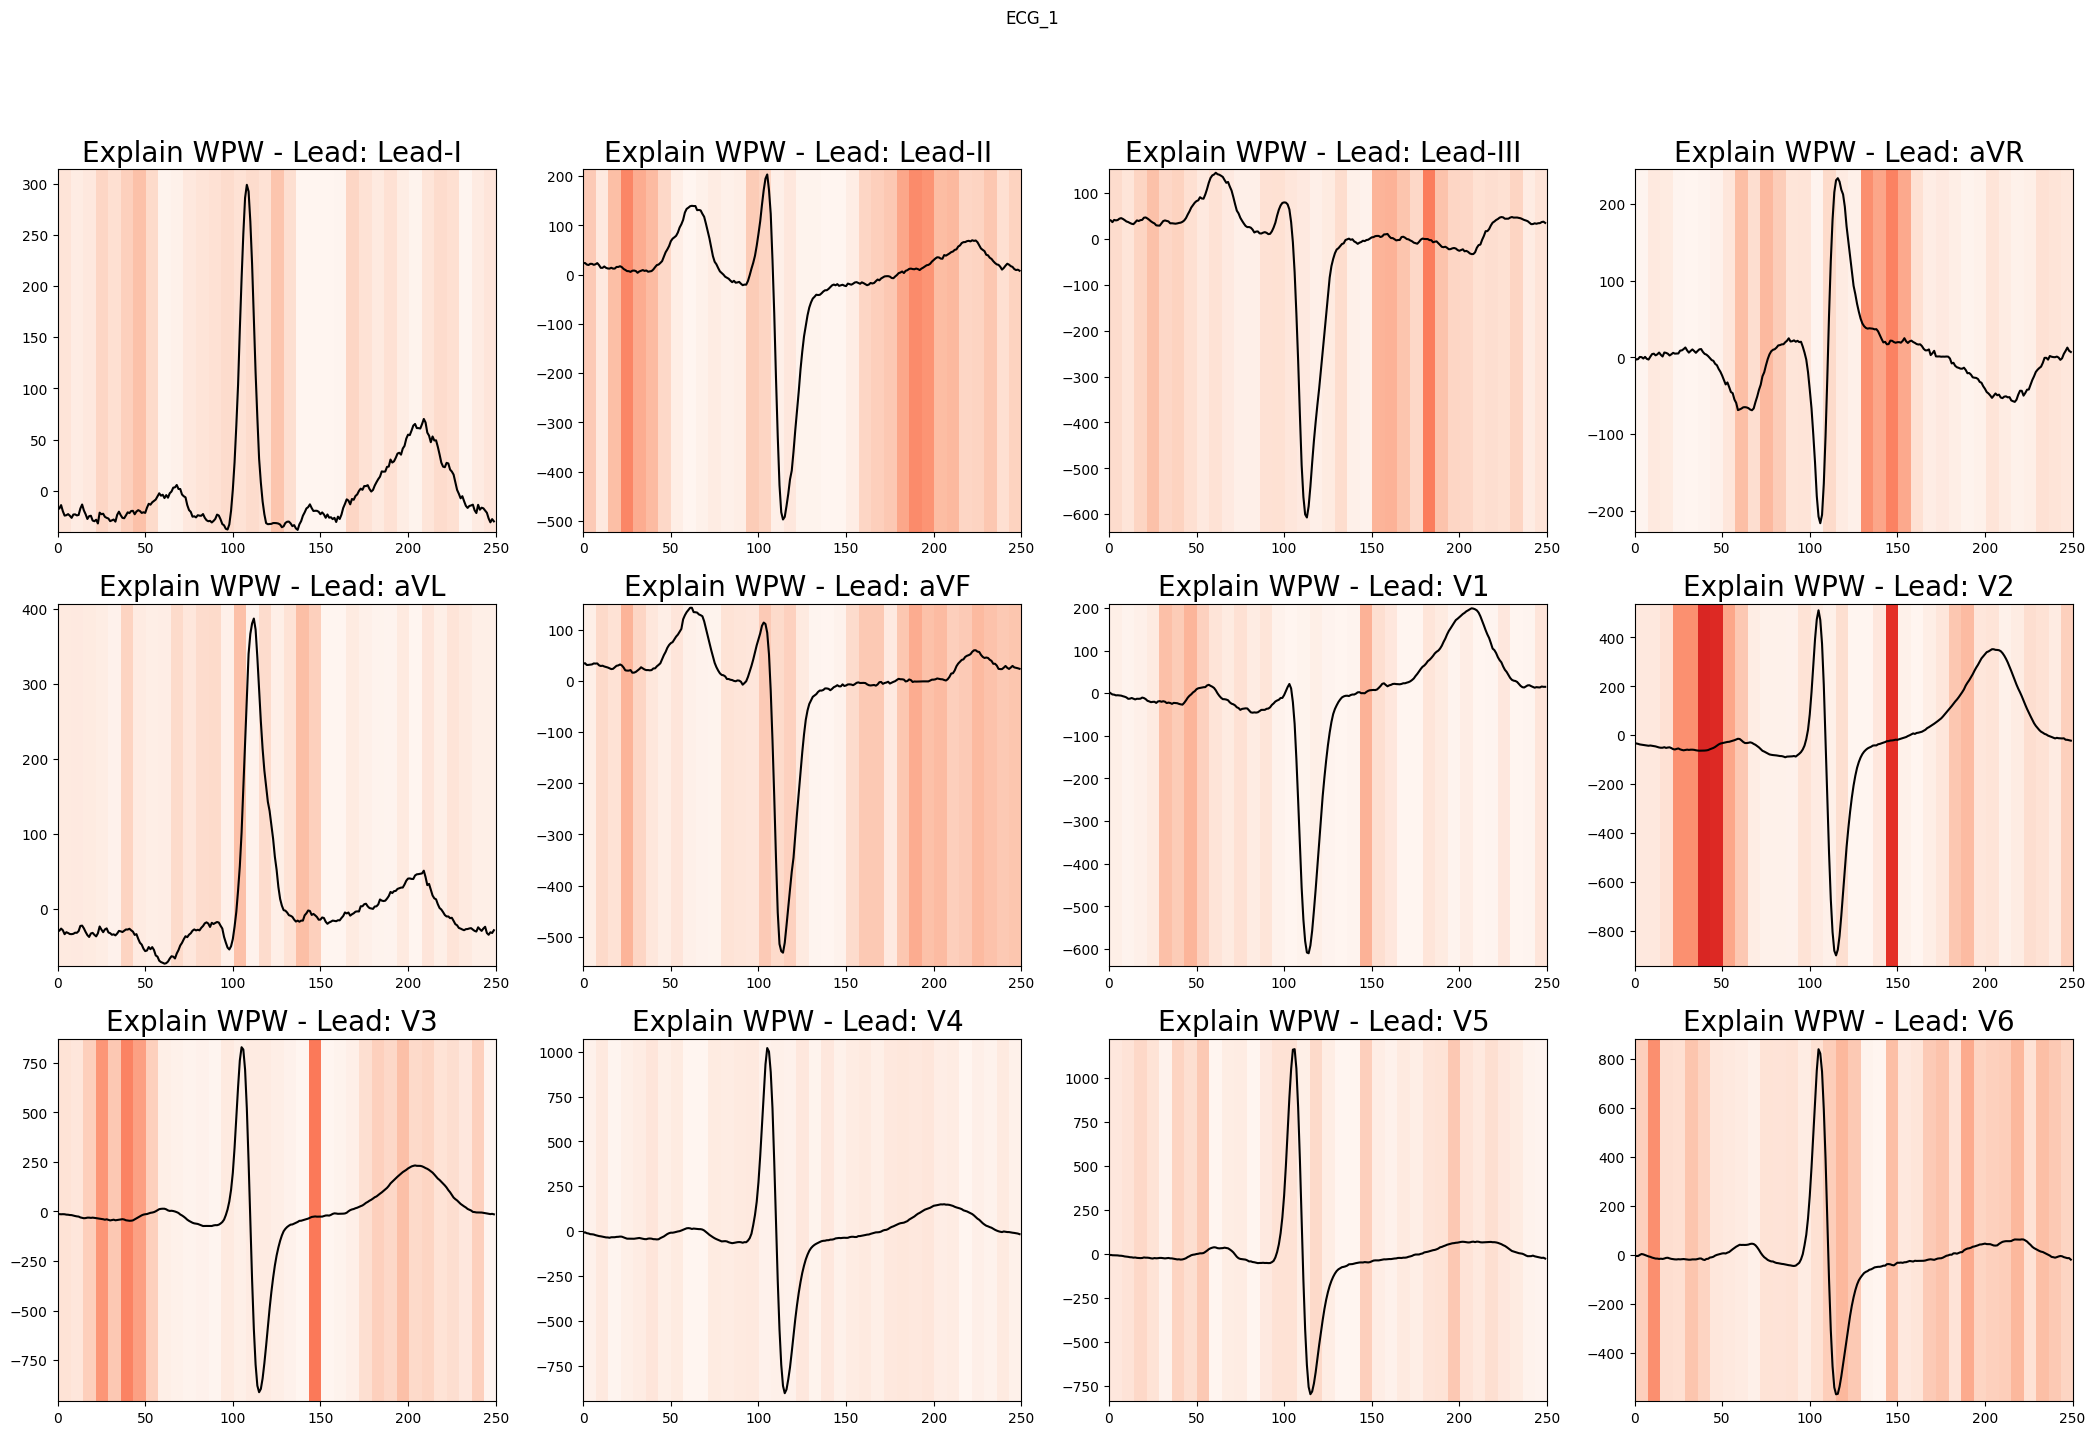

predicted labels: 
1/1 [==============================] - 0s 20ms/step
[0.66221726 0.33778277]
-----------------------
WPW = 1, Normal = 0
correct label is: 1.0
-----------------------
157/157 [==============================] - 11s 70ms/step


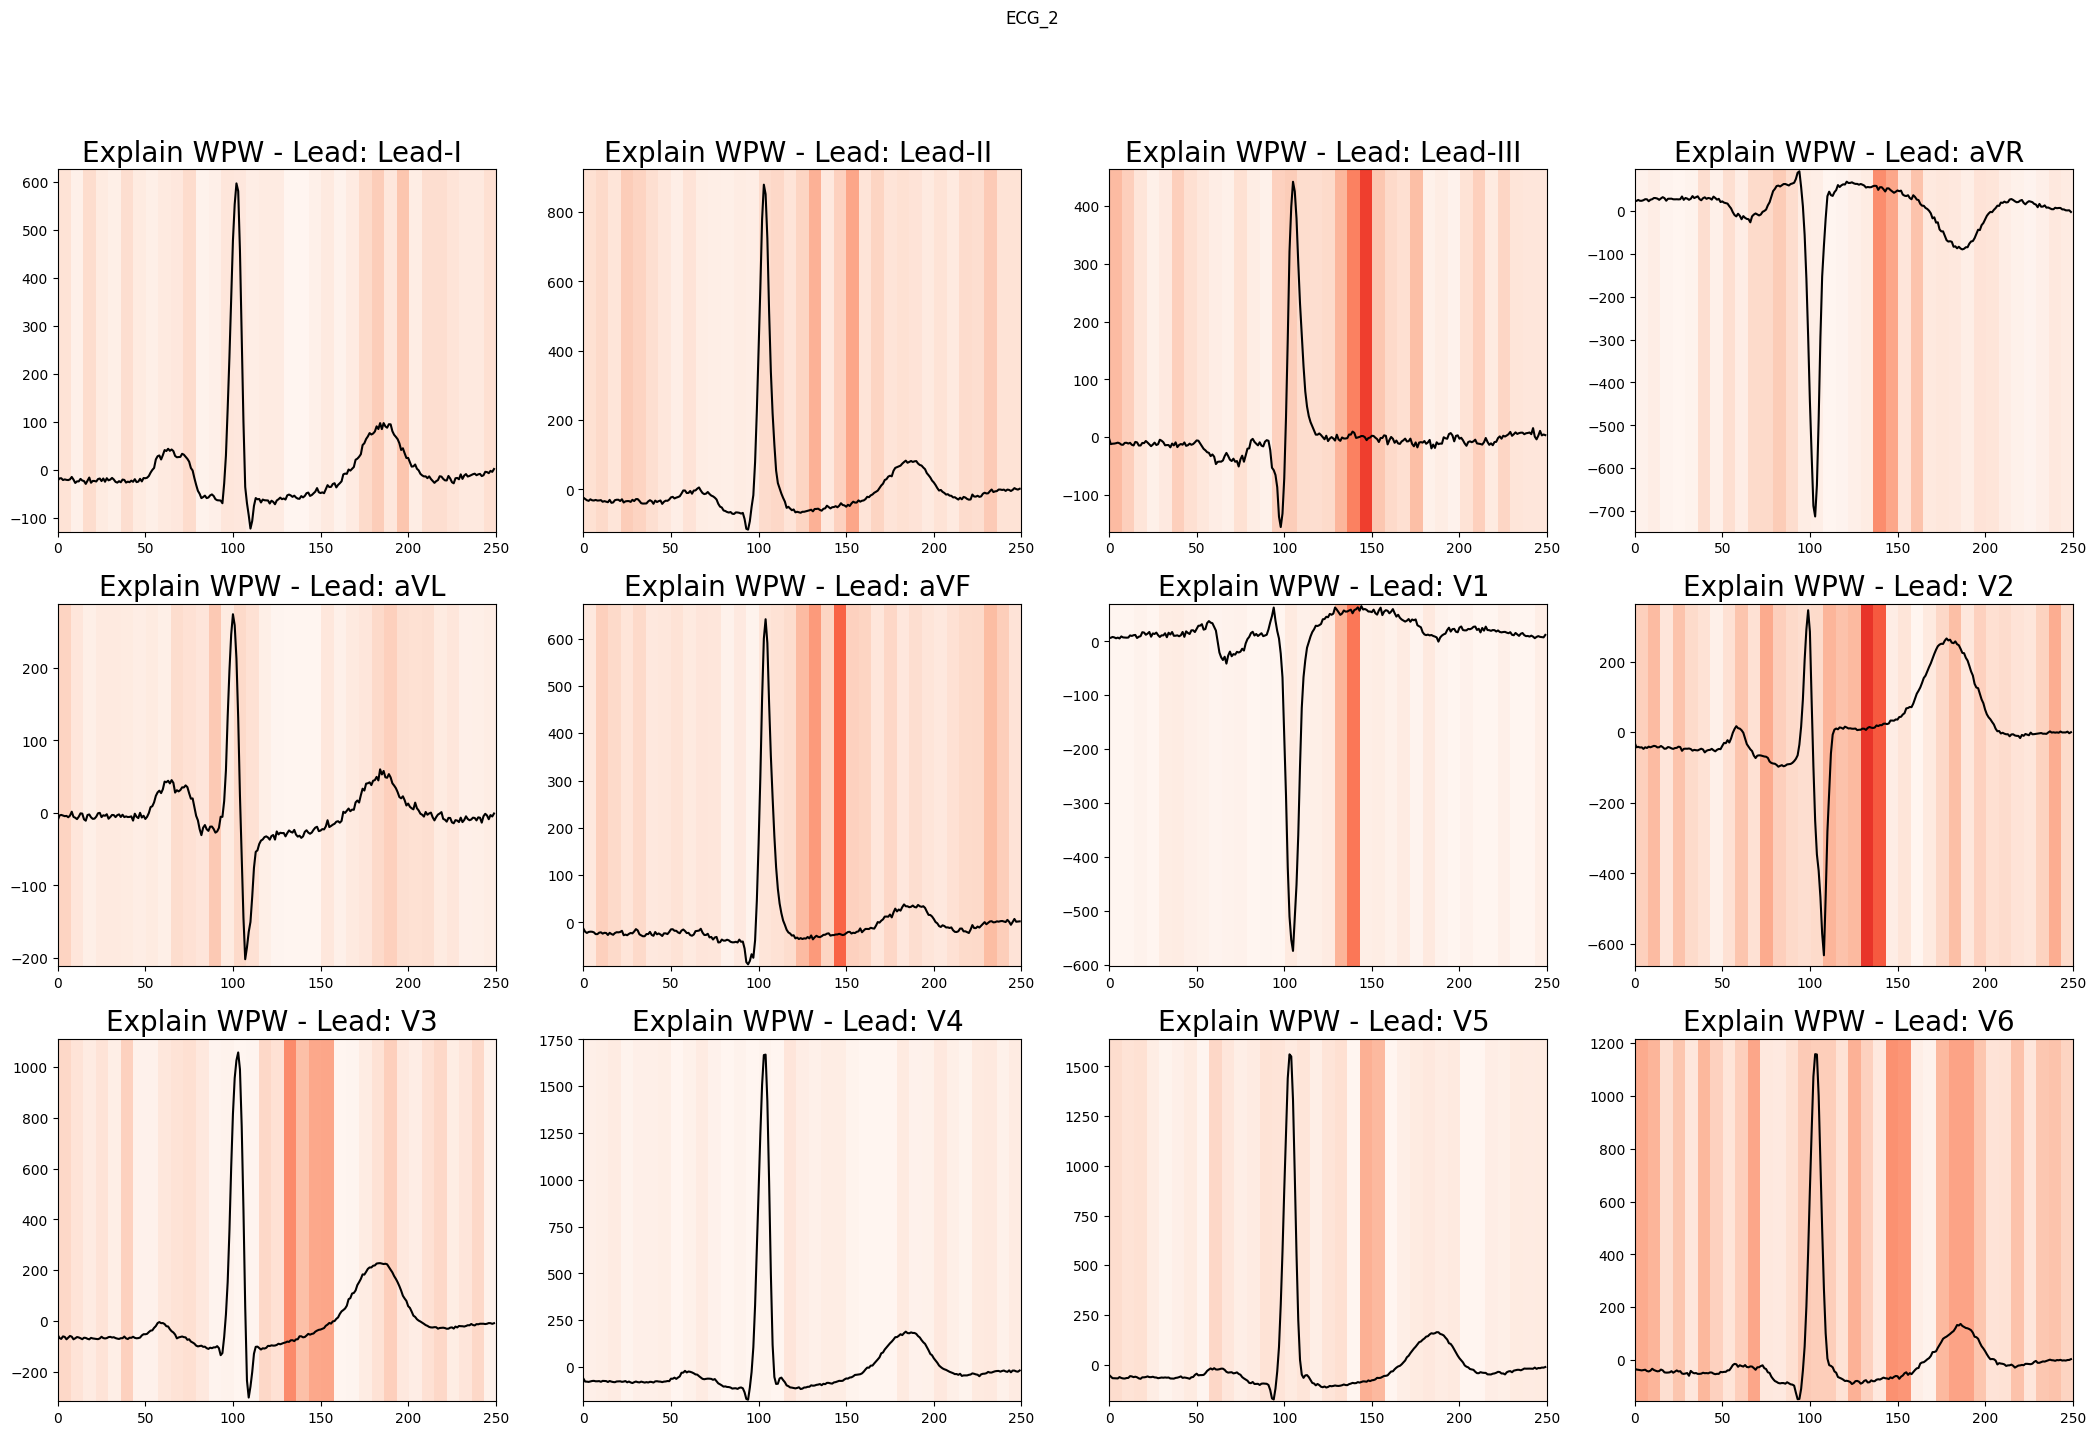

predicted labels: 
1/1 [==============================] - 0s 22ms/step
[0.69750285 0.30249712]
-----------------------
WPW = 1, Normal = 0
correct label is: 1.0
-----------------------
157/157 [==============================] - 11s 69ms/step


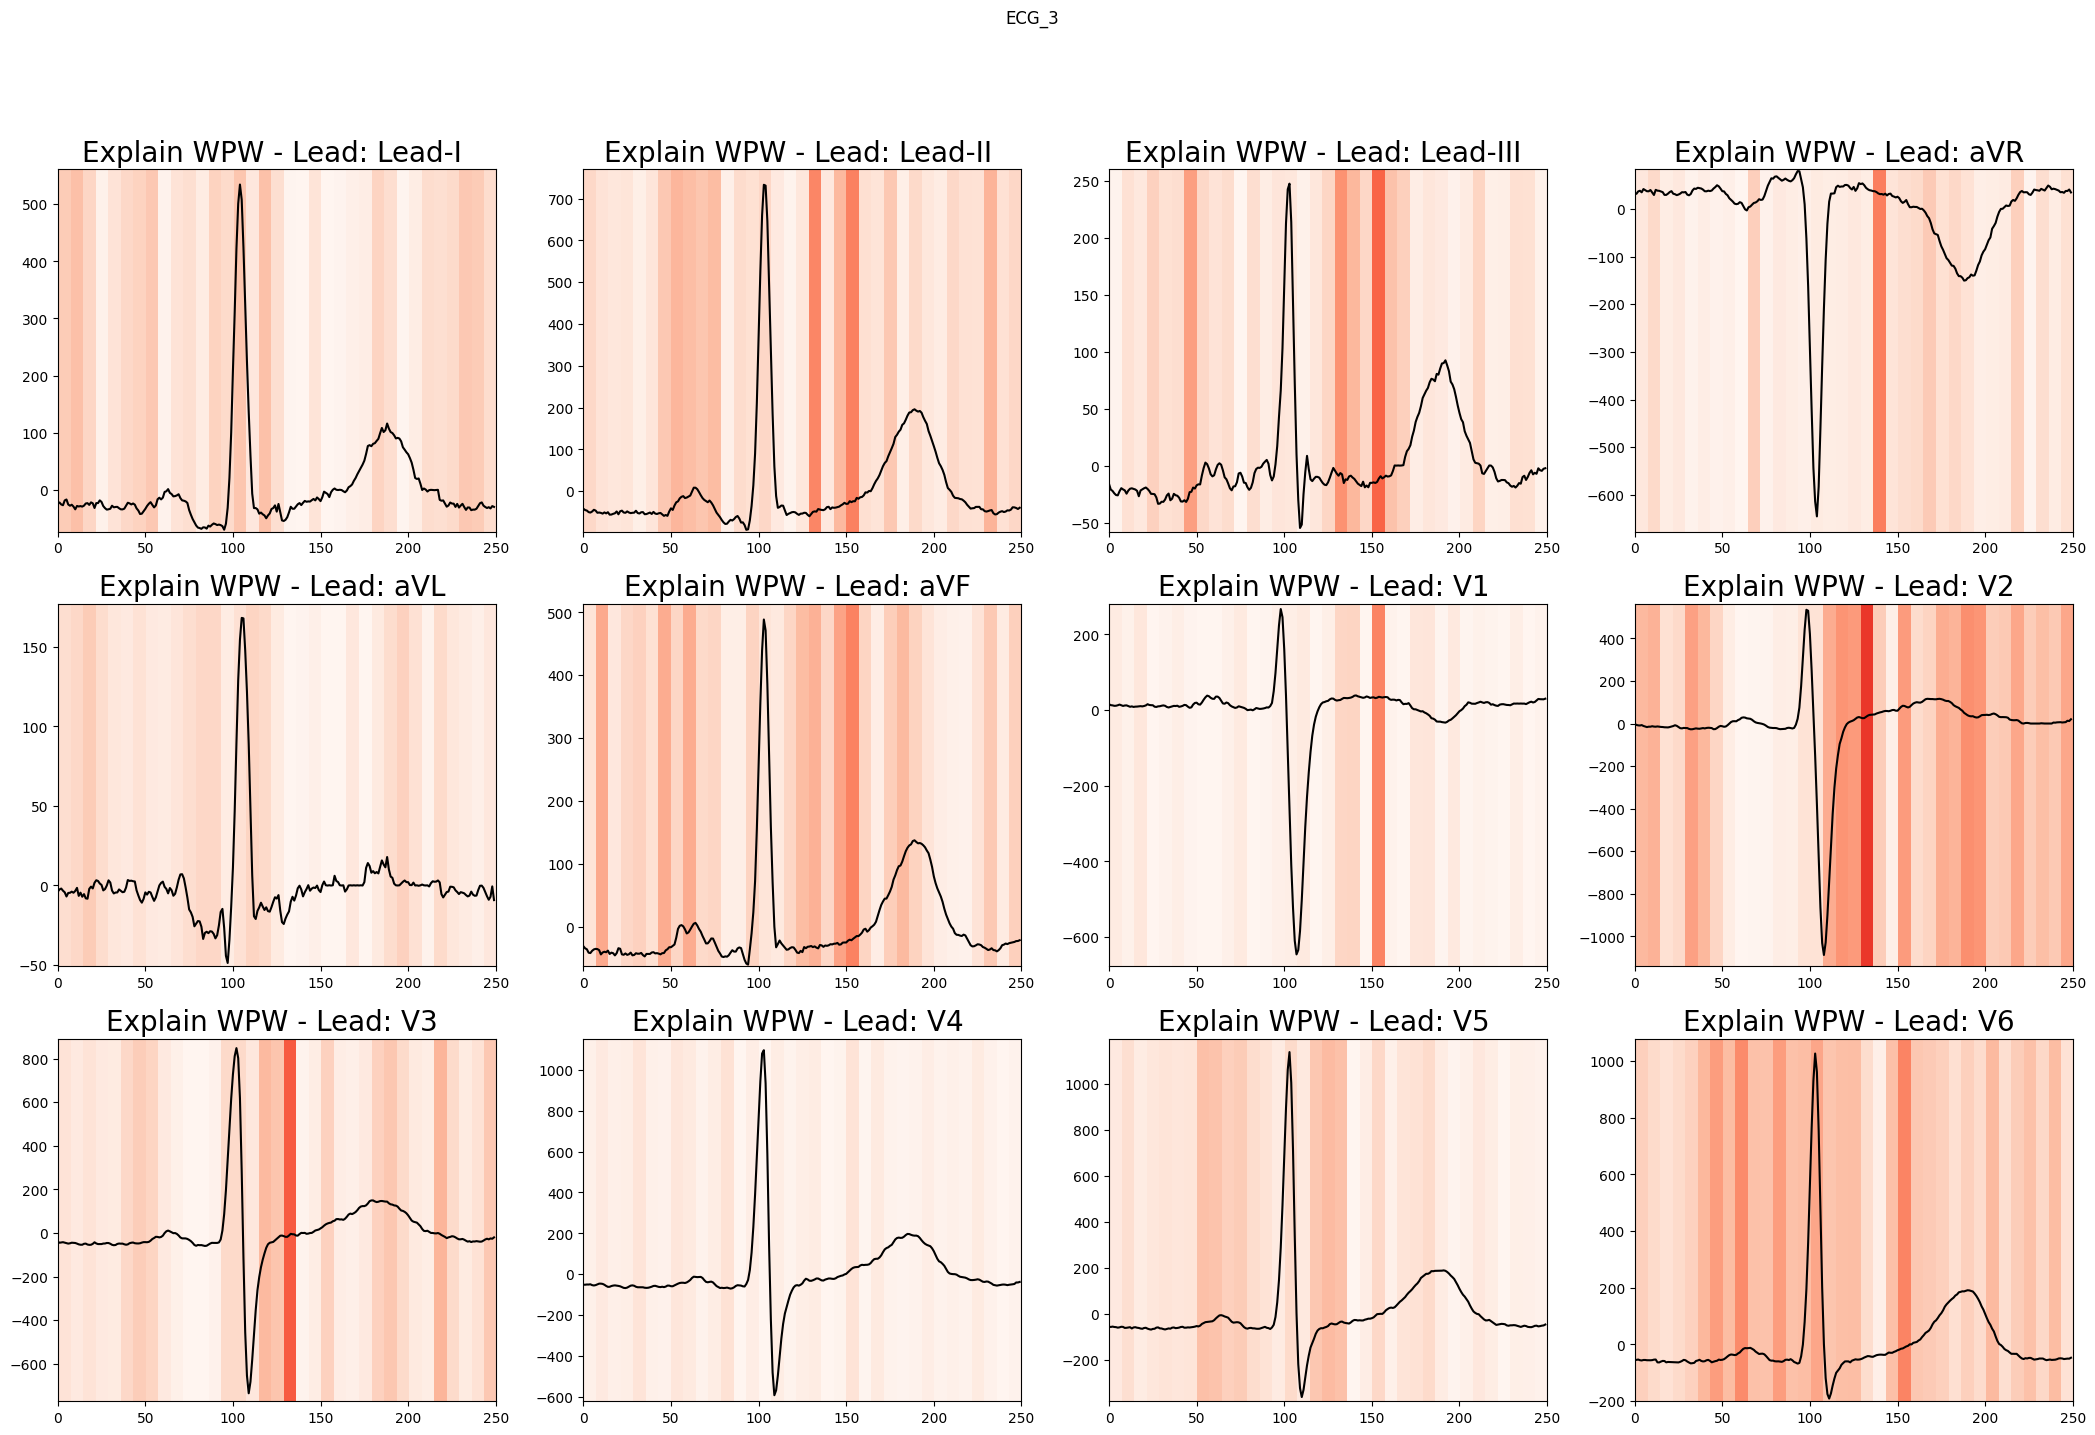

In [36]:
for i,j in enumerate(X_val[:4]):
    print("predicted labels: ")
    print(model.predict(np.expand_dims(j,axis=0))[0])
    print("-----------------------")
    print("WPW = 1, Normal = 0")
    print("correct label is: {}".format(y_val[-1*(i+1)]))
    print("-----------------------")
    exp = explainer.explain_instance(np.expand_dims(j,axis=0),model.predict, num_features=250*12)
    explanations = exp.as_list()
    heatmap = np.zeros([12,250])

    for k in explanations:
        if k[0].split("_")[0]=='Lead-I':
            heatmap[0][int(k[0].split("-")[-1])]=k[1]
        elif k[0].split("_")[0]=='Lead-II':
            heatmap[1][int(k[0].split("-")[-1])]=k[1]
        elif k[0].split("_")[0]=='Lead-III':
            heatmap[2][int(k[0].split("-")[-1])]=k[1]
        elif k[0].split("_")[0]=='aVR':
            heatmap[3][int(k[0].split("-")[-1])]=k[1]
        elif k[0].split("_")[0]=='aVL':
            heatmap[4][int(k[0].split("-")[-1])]=k[1]
        elif k[0].split("_")[0]=='aVF':
            heatmap[5][int(k[0].split("-")[-1])]=k[1]
        elif k[0].split("_")[0]=='V1':
            heatmap[6][int(k[0].split("-")[-1])]=k[1]
        elif k[0].split("_")[0]=='V2':
            heatmap[7][int(k[0].split("-")[-1])]=k[1]
        elif k[0].split("_")[0]=='V3':
            heatmap[8][int(k[0].split("-")[-1])]=k[1]
        elif k[0].split("_")[0]=='V4':
            heatmap[9][int(k[0].split("-")[-1])]=k[1]
        elif k[0].split("_")[0]=='V5':
            heatmap[10][int(k[0].split("-")[-1])]=k[1]
        elif k[0].split("_")[0]=='V6':
            heatmap[11][int(k[0].split("-")[-1])]=k[1]
            
    test_heatmap = heatmap.copy()
    test_heatmap[np.where(heatmap > 0)] = 0.0
    test_heatmap = abs(test_heatmap)
    leads = ["Lead-I","Lead-II", "Lead-III","aVR","aVL","aVF","V1","V2","V3","V4","V5","V6"]
    plt.figure(figsize=(26, 16))
    for l in range(12):
        plt.subplot(3, 4, l + 1)
        plt.title("Explain WPW - Lead: {} ".format(leads[l]), fontsize=20)

        plt.imshow(np.expand_dims(average_and_rebin(test_heatmap[l],7),axis=0),cmap='Reds', aspect="auto", interpolation='nearest',extent=[0,250,round(j[:,l].min()*1.05),round(j[:,l].max()*1.05)],
                   vmin=test_heatmap.min(), vmax=test_heatmap.max(), alpha=1.0)
        plt.plot(j[:,l],'k')

    # plt.colorbar()
    plt.savefig("wpw_{}.png".format(i),dpi=300)
    plt.suptitle("ECG_{}".format(i))
    plt.show()   

# Grad-CAM:

In [37]:
def grad_cam(layer_name, data, model):
    grad_model = tf.keras.models.Model(
    [model.inputs], [model.get_layer(layer_name).output, model.output]
)
    last_conv_layer_output, preds = grad_model(data)

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(data)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    grads = tape.gradient(class_channel, last_conv_layer_output)


    pooled_grads = tf.reduce_mean(grads, axis=(0))

    last_conv_layer_output = last_conv_layer_output[0]

    heatmap = last_conv_layer_output * pooled_grads
    heatmap = tf.reduce_mean(heatmap, axis=(1))
    heatmap = np.expand_dims(heatmap,0)
    return heatmap

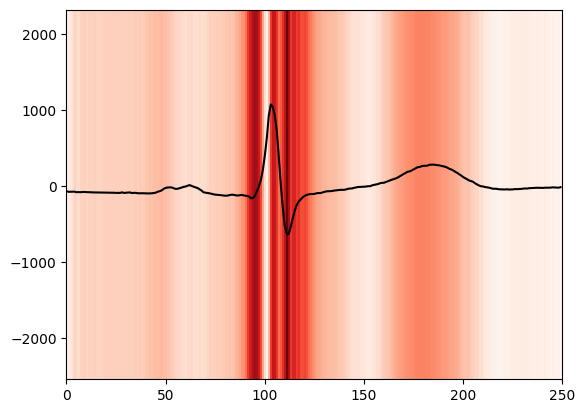

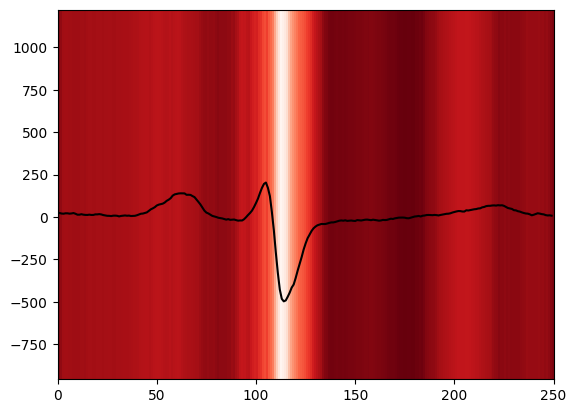

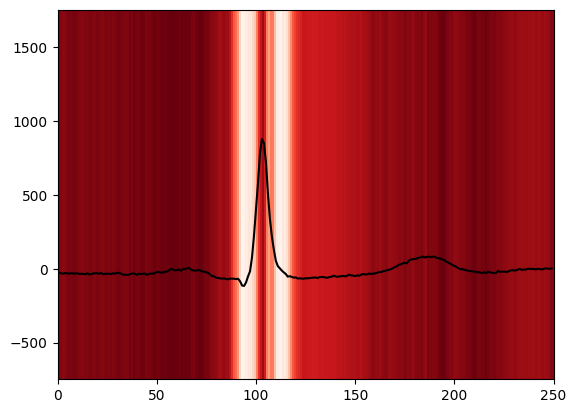

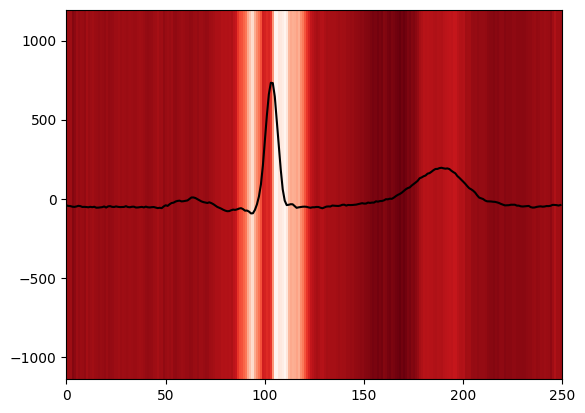

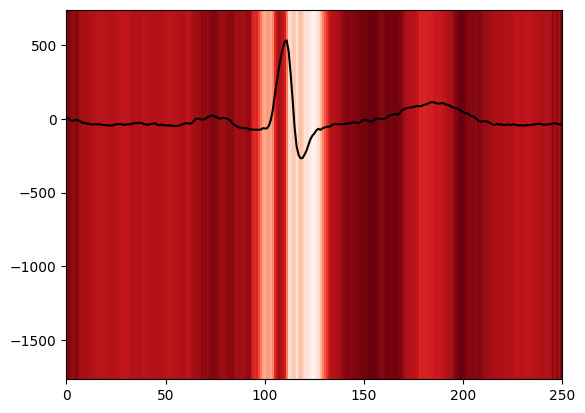

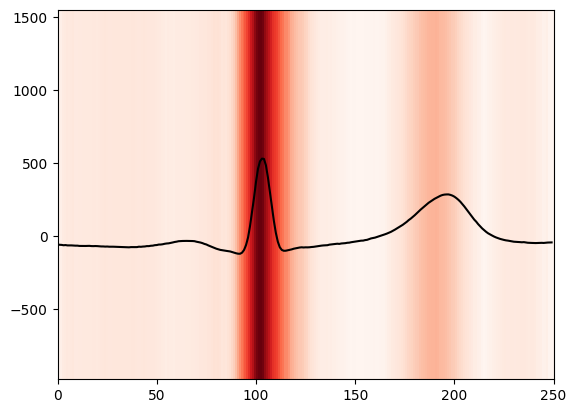

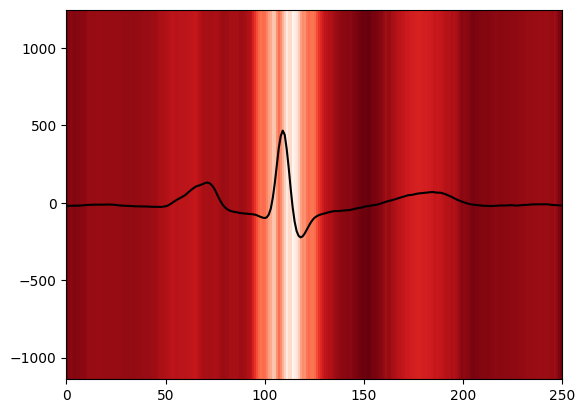

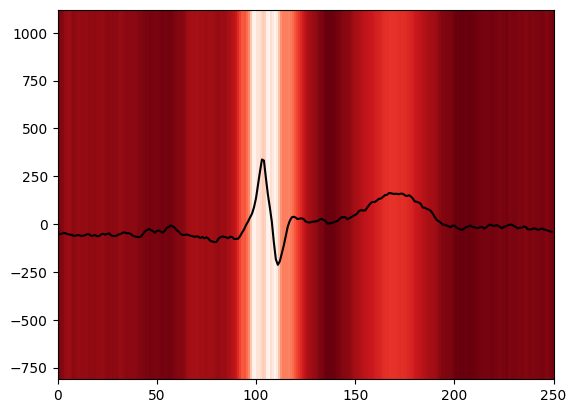

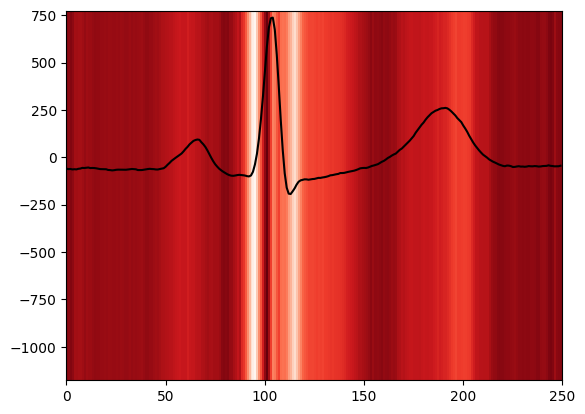

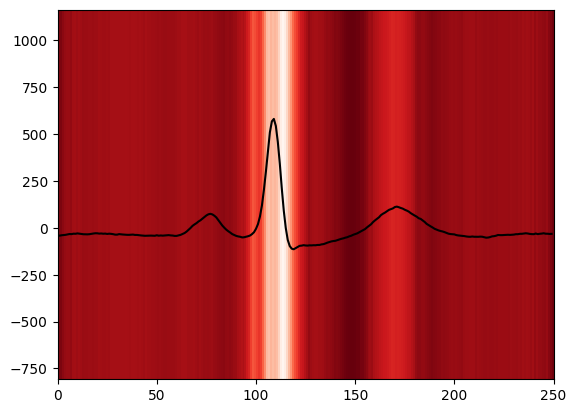

In [38]:
for example in X_val[:10]:
    exp = grad_cam("last_conv", np.expand_dims(example,0), model)
    plt.imshow(exp,cmap='Reds', aspect="auto", interpolation='nearest',extent=[0,250,round(example.min()*1.05),round(example.max()*1.05)],
           vmin=exp.min(), vmax=exp.max(), alpha=1.0)
    plt.plot(example[:,1],'k')
    plt.show()